**This notebook is the annotated version of the original [notebook](https://www.kaggle.com/code/radek1/co-visitation-matrix-simplified-imprvd-logic) by @radek1**

This notebook builds on [the work](https://www.kaggle.com/code/vslaykovsky/co-visitation-matrix) by [@vslaykovsky](https://www.kaggle.com/vslaykovsky). As suggested by [@cdeotte](https://www.kaggle.com/cdeotte) [here](https://www.kaggle.com/code/cdeotte/test-data-leak-lb-boost) I am including test information in clculating the co-visitation matrix.

Here I provide a simplified implementation that is easier to follow and that can also be more easily extended!

Please find some additional discussion on this notebook in this [thread](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364210).

**Would appreciate [your upvote on the thread](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364210) to increase visibility.** 🙏

Because the code is simpler, it was straightforward to modify the logic and make a couple of different decisions to achieve a better result.

Additionally, I am also using a version of the dataset that I shared [here](https://www.kaggle.com/competitions/otto-recommender-system/discussion/363843). This further simplifies matters as we no longer have to read the data from `jasonl` files!

**If you like this notebook, please upvote! Thank you! 😊**

## You might also find useful:

* [💡 Do not disregard longer sessions -- they contribute disproportionately to the competition metric!](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364375)
* [🐘 the elephant in the room -- high cardinality of targets and what to do about this](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364722)
* [📅 Dataset for local validation created using organizer's repository (parquet files)](https://www.kaggle.com/competitions/otto-recommender-system/discussion/364534)


### Update:

* added sorting of `AIDs` in test based on number of clicks from [Multiple clicks vs latest items](https://www.kaggle.com/code/pietromaldini1/multiple-clicks-vs-latest-items) by [pietromaldini1](https://www.kaggle.com/pietromaldini1)
* added speed improvements from [Fast Co-Visitation Matrix](https://www.kaggle.com/code/pietromaldini1/multiple-clicks-vs-latest-items) by [dpalbrecht](https://www.kaggle.com/dpalbrecht)
* added weigting by type of `AIDs` in test from [Item type vs multiple clicks vs latest items](https://www.kaggle.com/code/ingvarasgalinskas/item-type-vs-multiple-clicks-vs-latest-items) by [ingvarasgalinskas](https://www.kaggle.com/ingvarasgalinskas)

## imports

In [ ]:
# make sure fastkaggle is install and imported
import os

try: import fastkaggle
except ModuleNotFoundError:
    os.system("pip install -Uq fastkaggle")

from fastkaggle import *

# use fastdebug.utils 
if iskaggle: os.system("pip install nbdev snoop")

if iskaggle:
    path = "../input/fastdebugutils0"
    import sys
    sys.path
    sys.path.insert(1, path)
    import utils as fu
    from utils import *
else: 
    from fastdebug.utils import *
    import fastdebug.utils as fu

In [ ]:
import pandas as pd
import numpy as np

## rd: recsys - otto - covisitation_simplified - read the dataset files

### rd: recsys - otto - covisitation_simplified - read parquet and csv from dataset, pd.read_parquet('copy & paste'), pd.read_csv('copy & paste')

In [ ]:
train = pd.read_parquet('../input/otto-full-optimized-memory-footprint//train.parquet')
test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

sample_sub = pd.read_csv('../input/otto-recommender-system//sample_submission.csv')

In [ ]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [ ]:
test.head()

,session,aid,ts,type
0,12899779,59625,1661724000,0
1,12899780,1142000,1661724000,0
2,12899780,582732,1661724058,0
3,12899780,973453,1661724109,0
4,12899780,736515,1661724136,0


In [ ]:
sample_sub.head()

,session_type,labels
0,12899779_clicks,129004 126836 118524
1,12899779_carts,129004 126836 118524
2,12899779_orders,129004 126836 118524
3,12899780_clicks,129004 126836 118524
4,12899780_carts,129004 126836 118524


## rd: recsys - otto - covisitation_simplified - taking subset for fast experiment

### rd: recsys - otto - covisitation_simplified - subset based on entire sessions, train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session'], train[train.session.isin(lucky_sessions_train)]

In [ ]:
fraction_of_sessions_to_use = 0.000001 # 0.001 is recommended, but 0.000001 can finish in less than 4 minutes

In [ ]:
train.shape # how many rows

(216716096, 4)

In [ ]:
train.drop_duplicates(['session']).shape # how many unique sessions (drop rows with the same session)

(12899779, 4)

In [ ]:
subset_of_train_no_duplicate = train.sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
subset_of_train_no_duplicate.shape # take 0.000001 from entire train

(217,)

In [ ]:
lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
lucky_sessions_train.shape # take 0.000001 from a dataframe in which each row is an unique session

(13,)

In [ ]:
lucky_sessions_train.head()
lucky_sessions_train.reset_index(drop=True).head() # make index easier to see

161074658    7345999
136385904    5537326
165592490    7723696
134046856    5390256
136142264    5521908
Name: session, dtype: int32

In [ ]:
train.session.isin(lucky_sessions_train).sum() # how many rows under the 13 sessions

116

In [ ]:
if fraction_of_sessions_to_use != 1:
    lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
    subset_of_train = train[train.session.isin(lucky_sessions_train)]
    
    lucky_sessions_test = test.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
    subset_of_test = test[test.session.isin(lucky_sessions_test)]
else:
    subset_of_train = train
    subset_of_test = test

In [ ]:
subset_of_train.shape

(116, 4)

In [ ]:
subset_of_train

,session,aid,ts,type
47752837,1252181,1150072,1659396245,0
47752838,1252181,1053941,1659839377,0
47752839,1252181,1412178,1659839582,0
47752840,1252181,1412178,1659839601,1
47752841,1252181,567959,1659839627,0
...,...,...,...,...
209483943,12014664,635761,1661429463,0
209483944,12014664,635761,1661429657,1
209483945,12014664,635761,1661429811,1
209483946,12014664,1765902,1661429871,0


## rd: recsys - otto - covisitation_simplified - use session column as index

### rd: recsys - otto - covisitation_simplified - subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']]), [['session']] as Series not DataFrame

In [ ]:
# see the difference between 
subset_of_train[['session']], subset_of_train['session']

(            session
 47752837    1252181
 47752838    1252181
 47752839    1252181
 47752840    1252181
 47752841    1252181
 ...             ...
 209483943  12014664
 209483944  12014664
 209483945  12014664
 209483946  12014664
 209483947  12014664
 
 [116 rows x 1 columns],
 47752837      1252181
 47752838      1252181
 47752839      1252181
 47752840      1252181
 47752841      1252181
                ...   
 209483943    12014664
 209483944    12014664
 209483945    12014664
 209483946    12014664
 209483947    12014664
 Name: session, Length: 116, dtype: int32)

In [ ]:
subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])
subset_of_train

,session,aid,ts,type
session,,,,
1252181,1252181,1150072,1659396245,0
1252181,1252181,1053941,1659839377,0
1252181,1252181,1412178,1659839582,0
1252181,1252181,1412178,1659839601,1
1252181,1252181,567959,1659839627,0
...,...,...,...,...
12014664,12014664,635761,1661429463,0
12014664,12014664,635761,1661429657,1
12014664,12014664,635761,1661429811,1


In [ ]:
subset_of_test.index = pd.MultiIndex.from_frame(subset_of_test[['session']])
subset_of_test

,session,aid,ts,type
session,,,,
13993132,13993132,1096609,1662115398,0
14088154,14088154,14170,1662144895,0


### rd: recsys - otto - covisitation_simplified - get starting and end session timestamp, train.ts.min() test.ts.max()

In [ ]:
min_ts = train.ts.min()
max_ts = test.ts.max()

min_ts, max_ts

(1659304800, 1662328791)

## rd: recsys - otto - covisitation_simplified - create defaultdict+Counter to count occurences

### rd: recsys - otto - covisitation_simplified - create defaultdict on Counter for next_AIDs, next_AIDs = defaultdict(Counter)

In [ ]:
from collections import defaultdict, Counter
next_AIDs = defaultdict(Counter)
next_AIDs

defaultdict(collections.Counter, {})

## rd: recsys - otto - covisitation_simplified - use test for training, get subsets, sessions, sessions_train, sessions_test

In [ ]:
subsets = pd.concat([subset_of_train, subset_of_test]) # use test set for training too
sessions = subsets.session.unique() # unique sessions in subsets
sessions_train = subset_of_train.session.unique() # unique sessions in train
sessions_test = subset_of_test.session.unique() # unique sessions in test
len(sessions), len(sessions_train), len(sessions_test)

(15, 13, 2)

In [ ]:
subsets

,session,aid,ts,type
session,,,,
1252181,1252181,1150072,1659396245,0
1252181,1252181,1053941,1659839377,0
1252181,1252181,1412178,1659839582,0
1252181,1252181,1412178,1659839601,1
1252181,1252181,567959,1659839627,0
...,...,...,...,...
12014664,12014664,635761,1661429811,1
12014664,12014664,1765902,1661429871,0
12014664,12014664,635761,1661429890,0


In [ ]:
sessions[:5], sessions[-5:], sessions_train[:5], sessions_test[-5:]

(array([1252181, 4769706, 5390256, 5521908, 5537326], dtype=int32),
 array([10523604, 10556736, 12014664, 13993132, 14088154], dtype=int32),
 array([1252181, 4769706, 5390256, 5521908, 5537326], dtype=int32),
 array([13993132, 14088154], dtype=int32))

## rd: recsys - otto - covisitation_simplified - when one aid occurred, what other aid occurred and how often they(the other) occurred; and do this for every aid.

### rd: recsys - otto - covisitation_simplified - loop every chunk_size number unique sessions
### rd: recsys - otto - covisitation_simplified - take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
### rd: recsys - otto - covisitation_simplified - In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
### rd: recsys - otto - covisitation_simplified - merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
### rd: recsys - otto - covisitation_simplified - remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
### rd: recsys - otto - covisitation_simplified - add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
### rd: recsys - otto - covisitation_simplified - keep the rows if the two aids of a session are occurred within the same day on the right order
### rd: recsys - otto - covisitation_simplified - among all sessions/rows left(regardless which session we are looking at), for each aid occurred, count how often the other aid are occurred


In [ ]:
chunk_size = 30_000

for i in range(0, sessions.shape[0], chunk_size): # loop every 30_000 unique sessions
    
    #### take a chunk_size number of sessions (each session in its entirety, ie., many rows) from subsets as current_chunk
    
#     pp(i, sessions[i], sessions.shape[0]-1, i+chunk_size-1, sessions[min(sessions.shape[0]-1, i+chunk_size-1)])
    current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True) # to remove index column
#     pp(current_chunk.head(), current_chunk.tail())
#     pp(doc_sig(pd.DataFrame.reset_index)) 

    #### In current_chunk, from each session (in its entirety) only takes the last/latest 30 events and combine them to update current_chunk
#     pp(range(-30,0), list(range(-30,0)), doc_sig(current_chunk.groupby('session', as_index=False).nth))
    current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     pp(current_chunk[:31], current_chunk[30:61])

    #### merge an session of its entirety onto itself (help to see the relation between one aid and every other aid within each session)
    consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     pp(consecutive_AIDs[:30])
#     pp(consecutive_AIDs[29:61])

    #### remove all the rows which aid_x == aid_y (remove the row when the two articles are the same)
    consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
    
    #### add a column named 'days_elapsed' which shows how many days passed between the two aids in a session
    consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     pp(consecutive_AIDs[:61])

    #### keep the rows if the two aids of a session are occurred within the same day on the right order
    consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
    
    #### among all sessions or all users, for each article occurred, count how often the other articles are occurred
    for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
        next_AIDs[aid_x][aid_y] += 1
    

In [ ]:
next_AIDs

defaultdict(collections.Counter,
            {1053941: Counter({1412178: 2,
                      567959: 2,
                      1590011: 1,
                      1410065: 1,
                      527209: 1}),
             1412178: Counter({567959: 4, 1590011: 2, 1410065: 2, 527209: 2}),
             567959: Counter({1590011: 2, 1410065: 2, 527209: 2}),
             1590011: Counter({1410065: 1, 527209: 1}),
             1410065: Counter({527209: 1}),
             118631: Counter({1810463: 2}),
             809254: Counter({252823: 1,
                      755752: 2,
                      473784: 2,
                      1043532: 2,
                      424449: 2}),
             252823: Counter({809254: 1,
                      755752: 1,
                      473784: 1,
                      1043532: 1,
                      424449: 1}),
             755752: Counter({473784: 1, 1043532: 1, 424449: 1}),
             473784: Counter({1043532: 1, 424449: 1}),
             1043532: Cou

### rd: recsys - otto - covisitation_simplified - remove some data objects to save RAM

In [ ]:
del train, subset_of_train, subsets # to save RAM

## rd: recsys - otto - covisitation_simplified - make predictions

## rd: recsys - otto - covisitation_simplified - under each session, put all aids into a list, put all action types into a list

### rd: recsys - otto - covisitation_simplified - put all article ids or type into a list under the same session, test.reset_index(drop=True).groupby('session')['aid'].apply(list)

In [ ]:
test, test.reset_index(drop=True)

(          session      aid          ts  type
 0        12899779    59625  1661724000     0
 1        12899780  1142000  1661724000     0
 2        12899780   582732  1661724058     0
 3        12899780   973453  1661724109     0
 4        12899780   736515  1661724136     0
 ...           ...      ...         ...   ...
 6928118  14571577  1141710  1662328774     0
 6928119  14571578   519105  1662328775     0
 6928120  14571579   739876  1662328775     0
 6928121  14571580   202353  1662328781     0
 6928122  14571581  1100210  1662328791     0
 
 [6928123 rows x 4 columns],
           session      aid          ts  type
 0        12899779    59625  1661724000     0
 1        12899780  1142000  1661724000     0
 2        12899780   582732  1661724058     0
 3        12899780   973453  1661724109     0
 4        12899780   736515  1661724136     0
 ...           ...      ...         ...   ...
 6928118  14571577  1141710  1662328774     0
 6928119  14571578   519105  1662328775     0
 69

In [ ]:

test_session_AIDs = test.reset_index(drop=True).groupby('session')['aid'].apply(list)
test_session_types = test.reset_index(drop=True).groupby('session')['type'].apply(list)

In [ ]:
test_session_AIDs
test_session_types

session
12899779                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [59625]
12899780                                                                                                                                                                                                                                                                                                                                                                                                         

session
12899779                                                                                                                                                                                                                   [0]
12899780                                                                                                                                                                                                       [0, 0, 0, 0, 0]
12899781                                                                                                                                                                                     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
12899782    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]
12899783                                                                                            

### rd: recsys - otto - covisitation_simplified - create some containers?

In [ ]:
labels = []

no_data = 0
no_data_all_aids = 0
type_weight_multipliers = {0: 1, 1: 6, 2: 3}
session_types = ['clicks', 'carts', 'orders']

### rd: recsys - otto - covisitation_simplified - loop every session, access all of its aids and types
### rd: recsys - otto - covisitation_simplified - when there are >= 20 aids in a session: 
### rd: recsys - otto - covisitation_simplified - assign logspaced weight to each aid under each session, as the latest aid should have higher weight for user action
### rd: recsys - otto - covisitation_simplified - create a defaultdict to store weight for each aid under a session???
### rd: recsys - otto - covisitation_simplified - loop each aid, weight, event_type of a session:
### rd: recsys - otto - covisitation_simplified - Within each session, accumulate the weight for each aid based on its occurences, event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, no duplicated aid here in this dict
### rd: recsys - otto - covisitation_simplified - sort a defaultdict from largest value to smallest, and then put its keys into a list
### rd: recsys - otto - covisitation_simplified - store the first 20 aids (the most weighted or most likely aids to be acted upon within a session) into the list 'labels'
### rd: recsys - otto - covisitation_simplified - when there are < 20 aids in a session: 
### rd: recsys - otto - covisitation_simplified - reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs --- to be continued

In [ ]:
idx = 0
for AIDs, types in zip(test_session_AIDs, test_session_types): #### for each session, get all of its aids and types
    if len(AIDs) >= 20:
        #### assign logspaced weight to each arcticle id under each session
#         pp(doc_sig(np.logspace),len(AIDs), np.logspace(0.1,1,len(AIDs),base=2, endpoint=True), np.logspace(0.1,1,len(AIDs),base=2, endpoint=False))
        weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         pp(weights)

        #### create a defaultdict to store weight for each id article under a session
        aids_temp=defaultdict(lambda: 0)
    
        #### loop each article id, its weight and its type from all aids, their weights, and types
#         pp(AIDs) # there are repeated aids
        for aid,w,t in zip(AIDs,weights,types): 
        
            #### Within each session, accumulate the weight for each aid based on its occurences, 
            #### event_type and logspaced weight; save the accumulated weight for each aid into a defaultdict, 
            #### no duplicated aid here in this dict
            aids_temp[aid] += w * type_weight_multipliers[t]
            
        #### sort a defaultdict from largest value to smallest, and then put its keys into a list
#         pp(aids_temp.items())
#         pp(sorted(aids_temp.items(), key=lambda item: -item[1]))
#         pp(sorted(aids_temp.items(), key=lambda item: item[1])) 
        sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         pp(aids_temp, sorted_aids)
#         break

        #### store the first 20 aids into the list 'labels'
        labels.append(sorted_aids[:20])
        
    else:
        
        #### reverse the order of AIDs, remove the duplicated, put into a list, reassign it to AIDs
#         if len(AIDs) > 10:
#             pp(AIDs, AIDs[::-1], dict.fromkeys(AIDs[::-1]), list(dict.fromkeys(AIDs[::-1])), doc_sig(dict.fromkeys))
# https://stackoverflow.com/questions/31633635/what-is-the-meaning-of-inta-1-in-python [::-1] means reverse order
#             pp(AIDs, list(dict.fromkeys(AIDs[::-1])), list(dict.fromkeys(AIDs[::1])), list(dict.fromkeys(AIDs)))
#             break
        AIDs = list(dict.fromkeys(AIDs[::-1]))
    
        #### keep track the length of AIDs
        AIDs_len_start = len(AIDs)
        
        candidates = []
        for AID in AIDs:
            #### if AID is in the keys of next_AIDs, then take the 20 most common other aids occurred when AID occurred into a list
            #### and add this list into the list candidate (not a list of list, just a merged list)
            if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         if len(candidates) > 0: 
#             pp(candidates, Counter(candidates), Counter(candidates).most_common(40))
#             break

        #### use Counter to find the first 40 most common aid in candidate, and if they are not in AIDs then merge them into AIDs list
        AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
        #### append the first 20 aids to labels
        labels.append(AIDs[:20])
        if candidates == []: no_data += 1
        if AIDs_len_start == len(AIDs): no_data_all_aids += 1
            
#         pp(AIDs, labels, no_data, no_data_all_aids)
#         idx += 1
#         if idx > 2: break

```
11:39:47.48 LOG:
11:39:47.49 .... AIDs = [59625]
11:39:47.49 .... labels = [[59625]]
11:39:47.49 .... no_data = 1
11:39:47.49 .... no_data_all_aids = 1
([59625], [[59625]], 1, 1)
11:39:47.50 LOG:
11:39:47.50 .... AIDs = [1142000,
11:39:47.50              736515,
11:39:47.50              973453,
11:39:47.50              582732,
11:39:47.50              76352,
11:39:47.50              1032776,
11:39:47.50              448755,
11:39:47.50              1660665,
11:39:47.50              481350,
11:39:47.50              1419849,
11:39:47.50              1712906,
11:39:47.50              1075100,
11:39:47.50              1403849,
11:39:47.50              1516571,
11:39:47.50              1344942,
11:39:47.50              876129]
11:39:47.50 .... labels = [[59625],
11:39:47.50                [1142000,
11:39:47.50                 736515,
11:39:47.50                 973453,
11:39:47.50                 582732,
11:39:47.50                 76352,
11:39:47.50                 1032776,
11:39:47.50                 448755,
11:39:47.50                 1660665,
11:39:47.50                 481350,
11:39:47.50                 1419849,
11:39:47.50                 1712906,
11:39:47.50                 1075100,
11:39:47.50                 1403849,
11:39:47.50                 1516571,
11:39:47.50                 1344942,
11:39:47.50                 876129]]
11:39:47.50 .... no_data = 1
11:39:47.50 .... no_data_all_aids = 1
([1142000,
  736515,
  973453,
  582732,
  76352,
  1032776,
  448755,
  1660665,
  481350,
  1419849,
  1712906,
  1075100,
  1403849,
  1516571,
  1344942,
  876129],
 [[59625],
  [1142000,
   736515,
   973453,
   582732,
   76352,
   1032776,
   448755,
   1660665,
   481350,
   1419849,
   1712906,
   1075100,
   1403849,
   1516571,
   1344942,
   876129]],
 1,
 1)
11:39:47.51 LOG:
11:39:47.51 .... AIDs = [918667, 199008, 194067, 57315, 141736, 626338, 1833745, 1617920, 703029]
11:39:47.51 .... labels = [[59625],
11:39:47.51                [1142000,
11:39:47.51                 736515,
11:39:47.51                 973453,
11:39:47.51                 582732,
11:39:47.51                 76352,
11:39:47.51                 1032776,
11:39:47.51                 448755,
11:39:47.51                 1660665,
11:39:47.51                 481350,
11:39:47.51                 1419849,
11:39:47.51                 1712906,
11:39:47.51                 1075100,
11:39:47.51                 1403849,
11:39:47.51                 1516571,
11:39:47.51                 1344942,
11:39:47.51                 876129],
11:39:47.51                [918667, 199008, 194067, 57315, 141736, 626338, 1833745, 1617920, 703029]]
11:39:47.51 .... no_data = 1
11:39:47.51 .... no_data_all_aids = 1
([918667, 199008, 194067, 57315, 141736, 626338, 1833745, 1617920, 703029],
 [[59625],
  [1142000,
   736515,
   973453,
   582732,
   76352,
   1032776,
   448755,
   1660665,
   481350,
   1419849,
   1712906,
   1075100,
   1403849,
   1516571,
   1344942,
   876129],
  [918667, 199008, 194067, 57315, 141736, 626338, 1833745, 1617920, 703029]],
 1,
 1)
add Codeadd Markdown
# >>> outputting results to CSV
​
labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]
pp(labels[:2], labels_as_strings[:2])
11:40:28.32 LOG:
11:40:28.33 .... labels[:2] = [[59625],
11:40:28.33                    [1142000,
11:40:28.33                     736515,
11:40:28.33                     973453,
11:40:28.33                     582732,
11:40:28.33                     76352,
11:40:28.33                     1032776,
11:40:28.33                     448755,
11:40:28.33                     1660665,
11:40:28.33                     481350,
11:40:28.33                     1419849,
11:40:28.33                     1712906,
11:40:28.33                     1075100,
11:40:28.33                     1403849,
11:40:28.33                     1516571,
11:40:28.33                     1344942,
11:40:28.33                     876129]]
11:40:28.33 .... labels_as_strings[:2] = ['59625',
11:40:28.33                               '1142000 736515 973453 582732 76352 1032776 448755 1660665 481350 1419849 '
11:40:28.33                               '1712906 1075100 1403849 1516571 1344942 876129']
([[59625],
  [1142000,
   736515,
   973453,
   582732,
   76352,
   1032776,
   448755,
   1660665,
   481350,
   1419849,
   1712906,
   1075100,
   1403849,
   1516571,
   1344942,
   876129]],
 ['59625',
  '1142000 736515 973453 582732 76352 1032776 448755 1660665 481350 1419849 1712906 1075100 1403849 1516571 1344942 876129'])
add Codeadd Markdown
```

In [ ]:
# >>> outputting results to CSV

labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]
pp(labels[:2], labels_as_strings[:2])

12:33:16.08 LOG:
12:33:16.53 .... labels[:2] = [[59625], [1142000, 736515, 973453, 582732]]
12:33:16.53 .... labels_as_strings[:2] = ['59625', '1142000 736515 973453 582732']


([[59625], [1142000, 736515, 973453, 582732]],
 ['59625', '1142000 736515 973453 582732'])

In [ ]:
pp(len(test_session_AIDs.index), len(labels_as_strings))
predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})


12:33:16.54 LOG:
12:33:16.55 .... len(test_session_AIDs.index) = 1671803
12:33:16.55 .... len(labels_as_strings) = 1671803


(1671803, 1671803)

In [ ]:
prediction_dfs = []

for st in session_types:
    modified_predictions = predictions.copy()
    modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
    prediction_dfs.append(modified_predictions)

In [ ]:
pp(prediction_dfs[:2])

12:41:51.17 LOG:
12:41:51.19 .... prediction_dfs[:2] = [            session_type  \
12:41:51.19                           0        12899779_clicks   
12:41:51.19                           1        12899780_clicks   
12:41:51.19                           2        12899781_clicks   
12:41:51.19                           3        12899782_clicks   
12:41:51.19                           4        12899783_clicks   
12:41:51.19                           ...                  ...   
12:41:51.19                           1671798  14571577_clicks   
12:41:51.19                           1671799  14571578_clicks   
12:41:51.19                           1671800  14571579_clicks   
12:41:51.19                           1671801  14571580_clicks   
12:41:51.19                           1671802  14571581_clicks   
12:41:51.19                           
12:41:51.19                                                                                                                                            

[            session_type  \
 0        12899779_clicks   
 1        12899780_clicks   
 2        12899781_clicks   
 3        12899782_clicks   
 4        12899783_clicks   
 ...                  ...   
 1671798  14571577_clicks   
 1671799  14571578_clicks   
 1671800  14571579_clicks   
 1671801  14571580_clicks   
 1671802  14571581_clicks   
 
                                                                                                                                                     labels  
 0                                                                                                                                                    59625  
 1                                                                                                                             1142000 736515 973453 582732  
 2                                                                                                                        918667 199008 194067 57315 141736  
 3        834354 5

In [ ]:
submission = pd.concat(prediction_dfs).reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

print(f'Test sessions that we did not manage to extend based on the co-visitation matrix: {no_data_all_aids}')

Test sessions that we did not manage to extend based on the co-visitation matrix: 1615211


The following plot (combined with the information printed above) is quite significant -- it show us how much data we are still missing, how many predictions are not at their maximum allowable length.

And there is never a point in not outputting all 20 AIDs for any given prediction!

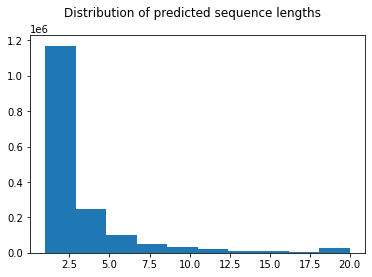

In [ ]:
from matplotlib import pyplot as plt

plt.hist([len(l) for l in labels]);
plt.suptitle('Distribution of predicted sequence lengths');

In [ ]:
# fraction_of_sessions_to_use = 0.000001 # takes about 3 mins to run

# import pandas as pd
# import numpy as np

# train = pd.read_parquet('../input/otto-full-optimized-memory-footprint//train.parquet')
# test = pd.read_parquet('../input/otto-full-optimized-memory-footprint/test.parquet')

# sample_sub = pd.read_csv('../input/otto-recommender-system//sample_submission.csv')

# if fraction_of_sessions_to_use != 1:
#     lucky_sessions_train = train.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
#     subset_of_train = train[train.session.isin(lucky_sessions_train)]
    
#     lucky_sessions_test = test.drop_duplicates(['session']).sample(frac=fraction_of_sessions_to_use, random_state=42)['session']
#     subset_of_test = test[test.session.isin(lucky_sessions_test)]
# else:
#     subset_of_train = train
#     subset_of_test = test

# subset_of_train.index = pd.MultiIndex.from_frame(subset_of_train[['session']])
# subset_of_test.index = pd.MultiIndex.from_frame(subset_of_test[['session']])

# chunk_size = 30_000
# min_ts = train.ts.min()
# max_ts = test.ts.max()

# from collections import defaultdict, Counter
# next_AIDs = defaultdict(Counter)

# subsets = pd.concat([subset_of_train, subset_of_test])
# sessions = subsets.session.unique()
# for i in range(0, sessions.shape[0], chunk_size):
#     current_chunk = subsets.loc[sessions[i]:sessions[min(sessions.shape[0]-1, i+chunk_size-1)]].reset_index(drop=True)
#     current_chunk = current_chunk.groupby('session', as_index=False).nth(list(range(-30,0))).reset_index(drop=True)
#     consecutive_AIDs = current_chunk.merge(current_chunk, on='session')
#     consecutive_AIDs = consecutive_AIDs[consecutive_AIDs.aid_x != consecutive_AIDs.aid_y]
#     consecutive_AIDs['days_elapsed'] = (consecutive_AIDs.ts_y - consecutive_AIDs.ts_x) / (24 * 60 * 60)
#     consecutive_AIDs = consecutive_AIDs[(consecutive_AIDs.days_elapsed >= 0) & (consecutive_AIDs.days_elapsed <= 1)]
    
#     for aid_x, aid_y in zip(consecutive_AIDs['aid_x'], consecutive_AIDs['aid_y']):
#         next_AIDs[aid_x][aid_y] += 1
    
# del train, subset_of_train, subsets

# session_types = ['clicks', 'carts', 'orders']
# test_session_AIDs = test.reset_index(drop=True).groupby('session')['aid'].apply(list)
# test_session_types = test.reset_index(drop=True).groupby('session')['type'].apply(list)

# labels = []

# no_data = 0
# no_data_all_aids = 0
# type_weight_multipliers = {0: 1, 1: 6, 2: 3}
# for AIDs, types in zip(test_session_AIDs, test_session_types):
#     if len(AIDs) >= 20:
#         weights=np.logspace(0.1,1,len(AIDs),base=2, endpoint=True)-1
#         aids_temp=defaultdict(lambda: 0)
#         for aid,w,t in zip(AIDs,weights,types): 
#             aids_temp[aid]+= w * type_weight_multipliers[t]
            
#         sorted_aids=[k for k, v in sorted(aids_temp.items(), key=lambda item: -item[1])]
#         labels.append(sorted_aids[:20])
#     else:
#         AIDs = list(dict.fromkeys(AIDs[::-1]))
#         AIDs_len_start = len(AIDs)
        
#         candidates = []
#         for AID in AIDs:
#             if AID in next_AIDs: candidates += [aid for aid, count in next_AIDs[AID].most_common(20)]
#         AIDs += [AID for AID, cnt in Counter(candidates).most_common(40) if AID not in AIDs]
        
#         labels.append(AIDs[:20])
#         if candidates == []: no_data += 1
#         if AIDs_len_start == len(AIDs): no_data_all_aids += 1

# # >>> outputting results to CSV

# labels_as_strings = [' '.join([str(l) for l in lls]) for lls in labels]

# predictions = pd.DataFrame(data={'session_type': test_session_AIDs.index, 'labels': labels_as_strings})

In [ ]:
# pp(len(test_session_AIDs.index), len(labels_as_strings))

In [ ]:
# predictions
# prediction_dfs = []

# for st in session_types:
#     modified_predictions = predictions.copy()
#     modified_predictions.session_type = modified_predictions.session_type.astype('str') + f'_{st}'
#     prediction_dfs.append(modified_predictions)

# submission = pd.concat(prediction_dfs).reset_index(drop=True)
# submission.to_csv('submission.csv', index=False)

# print(f'Test sessions that we did not manage to extend based on the co-visitation matrix: {no_data_all_aids}')